<a href="https://colab.research.google.com/github/venkataratnamb20/quicksilicon/blob/notebooks/ngspice_sky130_setup_with_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spice Simulation

# Setup

### Install simulator: ngspice

In [105]:
# install ngspice

!ngspice --version || apt-get install ngspice


******
** ngspice-36 : Circuit level simulation program
** The U. C. Berkeley CAD Group
** Copyright 1985-1994, Regents of the University of California.
** Copyright 2001-2020, The ngspice team.
** Please get your ngspice manual from http://ngspice.sourceforge.net/docs.html
** Please file your bug-reports at http://ngspice.sourceforge.net/bugrep.html
** Creation Date: Mon Mar 11 21:44:53 UTC 2024
******


### Download Technology files

Technolog files

- spice models
- standardcell definitions


In [106]:
# get sky130

import os
if not os.path.exists('skywater-pdk-libs-sky130_fd_pr'):
    # spice models
    !git clone https://github.com/google/skywater-pdk-libs-sky130_fd_pr.git

if not os.path.exists('skywater-pdk-libs-sky130_fd_sc_hd'):
    # standardcell definitions
    !git clone https://github.com/google/skywater-pdk-libs-sky130_fd_sc_hd.git

In [107]:
%%writefile .spiceinit


set ngbehavior=hsa
set ng_nomodcheck


Overwriting .spiceinit


## Example 1: RC Circuit

### Netlist

Important parts

- schematic
- control statements (follow this structure and play with different options)

result
- results are saved in .csv format (rc_tb.csv)

In [108]:
%%writefile rc_tb.cir

* RC LPF
*** Schemtic
.TITLE RC LPF
R1 vin vout 1M
R2 vout 0 1M
C2 vout 0 1p
V1 vin 0 DC 0 PULSE (0V 1.8V 1ns 10ps 10ps 1ns 2ns)

*** Control
.CONTROL
tran 10p 4n
option noinit
set wr_singlescale
set wr_vecnames
save all
save @r1[i] @r2[i]
save @c2[i]
run
wrdata rc_tb.csv V(vin) V(vout) @r1[i] @r2[i] @c2[i]
.ENDC
.END

Overwriting rc_tb.cir


### Run Simulation

Run Simulation with `ngspice` in batch mode


In [109]:
# run sim

!ngspice -b rc_tb.cir


Compatibility modes selected: hs a


Circuit: RC LPF

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


Initial Transient Solution
--------------------------

Node                                   Voltage
----                                   -------
vin                                          0
vout                                         0
v1#branch                                    0


No. of Data Rows : 441
Doing analysis at TEMP = 27.000000 and TNOM = 27.000000

Note: No ".plot", ".print", or ".fourier" lines; no simulations run


### Read and plot Result with python

The result (csv) can be opened with excel or any other tools.

Here is the example code to read and plot with python

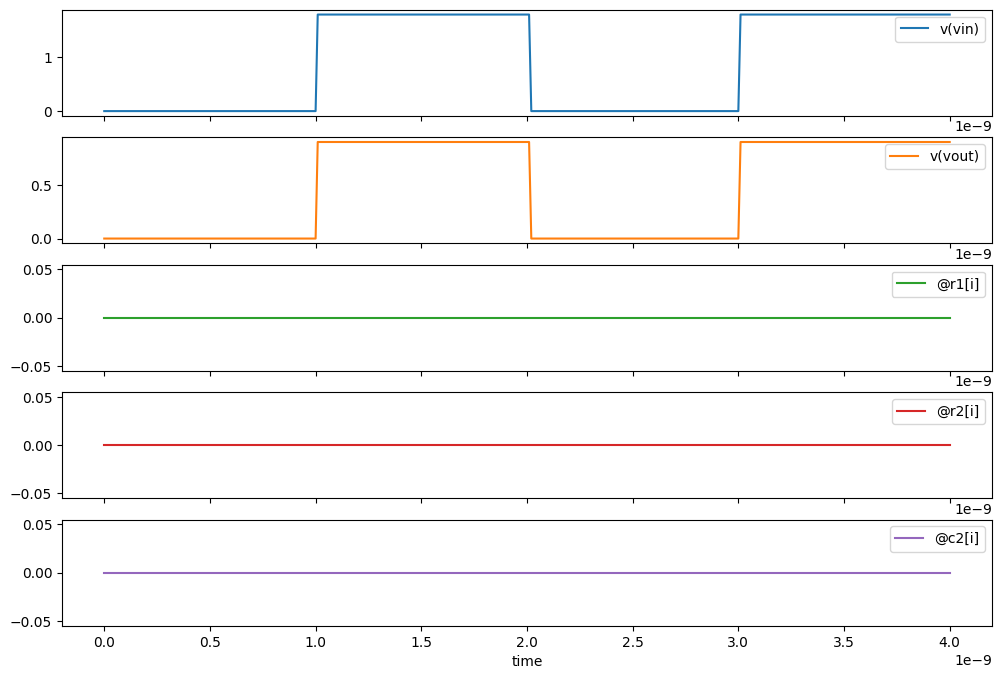

,v(vin),v(vout),@r1[i],@r2[i],@c2[i]
time,,,,,
0.000000e+00,0.0,0.0,0.0,0.0,0.0
1.000000e-13,0.0,0.0,0.0,0.0,0.0
2.000000e-13,0.0,0.0,0.0,0.0,0.0
4.000000e-13,0.0,0.0,0.0,0.0,0.0
8.000000e-13,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
3.964190e-09,1.8,0.9,0.0,0.0,0.0
3.974190e-09,1.8,0.9,0.0,0.0,0.0
3.984190e-09,1.8,0.9,0.0,0.0,0.0


In [110]:
# read data with python
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("rc_tb.csv", delim_whitespace = True, skip_blank_lines=True ).set_index('time')
data.plot(subplots=True, figsize=(12, 8))
plt.show()
data

## Example 2: Bipolar Amplifier

### Netlist

Important parts

- schematic
- control statements (follow this structure and play with different options)

result
- results are saved in .csv format (bipamp_tb.csv)

In [111]:
%%writefile bipamp_tb.cir

* bipolar amplifier
* file bipamp.cir
.model BC546B npn ( IS=7.59E-15 VAF=73.4 BF=480 IKF=0.0962 NE=1.2665
+ ISE=3.278E-15 IKR=0.03 ISC=2.00E-13 NC=1.2 NR=1 BR=5 RC=0.25 CJC=6.33E-12
+ FC=0.5 MJC=0.33 VJC=0.65 CJE=1.25E-11 MJE=0.55 VJE=0.65 TF=4.26E-10
+ ITF=0.6 VTF=3 XTF=20 RB=100 IRB=0.0001 RBM=10 RE=0.5 TR=1.50E-07)
R3 vcc intc 10k
R1 vcc intb 68k
R2 intb 0 10k
Cout out intc 10u
Cin intb in 10u
VCC vcc 0 5
Vin in 0 dc 0 ac 1 sin(0 1m 500)
RLoad out 0 100k
Q1 intc intb 0 BC546B
.tran 10u 10m
*.ac dec 10 10 1Meg
.options savecurrents

* Control statements
.CONTROL
    option noinit
    set wr_singlescale
    set wr_vecnames
    save all
    save @r1[i]
    save vcc#branch
    run
    * write data to csv
    wrdata bipamp_tb.csv V(in) V(out) @r1[i]
.ENDC
.end

Overwriting bipamp_tb.cir


### Run Simulation

Run Simulation with `ngspice` in batch mode


In [112]:
!ngspice -b bipamp_tb.cir


Compatibility modes selected: hs a


Circuit: 

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


No. of Data Rows : 1008
Note: No ".plot", ".print", or ".fourier" lines; no simulations run


### Read and plot Result with python

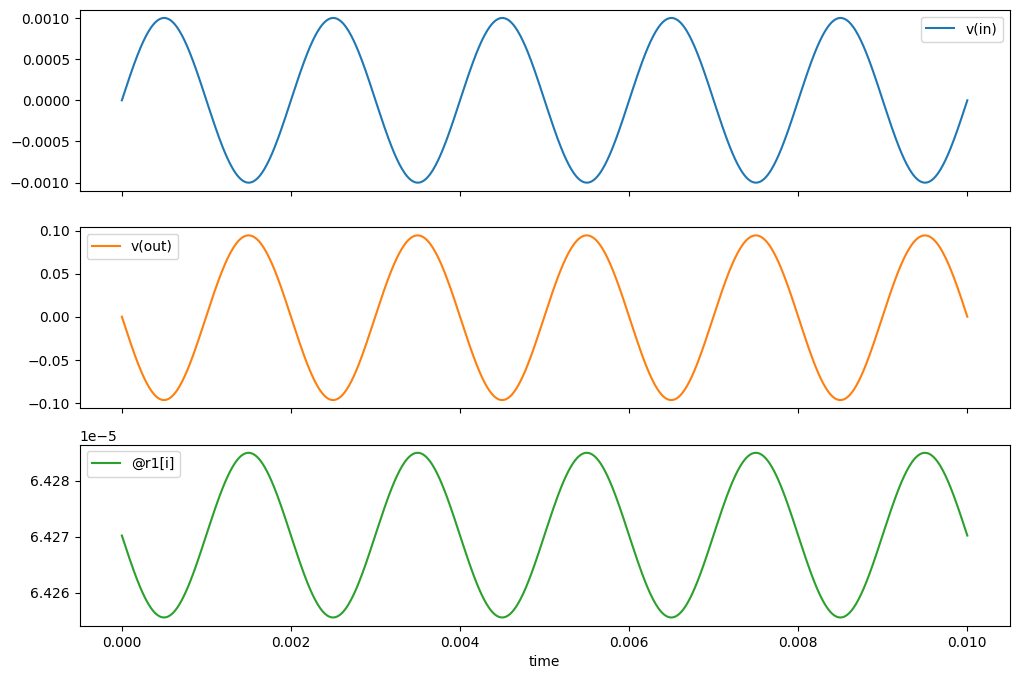

,v(in),v(out),@r1[i]
time,,,
0.000000e+00,0.000000e+00,0.000000,0.000064
1.000000e-07,3.141593e-07,-0.000016,0.000064
2.000000e-07,6.283185e-07,-0.000041,0.000064
4.000000e-07,1.256637e-06,-0.000095,0.000064
8.000000e-07,2.513271e-06,-0.000216,0.000064
...,...,...,...
9.962800e-03,-1.166014e-04,0.011127,0.000064
9.972800e-03,-8.534736e-05,0.008146,0.000064
9.982800e-03,-5.400910e-05,0.005153,0.000064


In [113]:
# read data with python

import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("bipamp_tb.csv", delim_whitespace = True, skip_blank_lines=True )
data = data.set_index('time')
data.plot(subplots=True, figsize=(12, 8))
plt.show()

data

## Example 3: Sky130: MOSFET

### Netlist

Important parts

- Add technology library and cell definition if required
- schematic
- control statements (follow this structure and play with different options)

result
- results are saved in .csv format (mosfet_tb.csv)


In [114]:
%%writefile mosfet_tb.cir

* nMOS Testbench
.title common source amplifier with nMOS

* technolyg- spice models
* .lib /usr/local/share/pdk/sky130A/libs.tech/ngspice/sky130.lib.spice tt
.lib /content/skywater-pdk-libs-sky130_fd_pr/models/sky130.lib.spice tt

* schematic definition
XMN0 DRAIN GATE VGND VGND sky130_fd_pr__nfet_01v8 l=0.5 w=1.5 m=1
Vgnd VGND 0 0
Vdd VPWR VGND 1.8
R VPWR DRAIN 10k
VVin GATE VGND DC 0V PULSE(0V 1.8V 1ns 10ps 10ps 1ns 2ns)

* Control statements
.CONTROL
    tran 10p 4n
    set filetype=ascii
    option noinit
    set wr_singlescale
    set wr_vecnames
    save all
    save allcurrents
    run
    wrdata mosfet_tb.csv V(DRAIN) V(GATE) Vdd#branch
.ENDC
.END

Overwriting mosfet_tb.cir


### Run Simulation

Run Simulation with `ngspice` in batch mode


In [115]:
# run sim

!ngspice -b mosfet_tb.cir


Compatibility modes selected: hs a



Circuit: common source amplifier with nMOS

option SCALE: Scale is set to 1e-06 for instance and model parameters
Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


Initial Transient Solution
--------------------------

Node                                   Voltage
----                                   -------
sky130_fd_pr__esd_nfet_05v0_nvt.pm3               0
                                             0
drain                                      1.8
gate                                         0
vgnd                                         0
vpwr                                       1.8
vvin#branch                                  0
vdd#branch                        -1.94583e-12
vgnd#branch                       -1.05839e-20

 Reference value :  0.00000e+00
No. of Data Rows : 427
Doing analysis at TEMP = 27.000000 and TNOM = 27.000000

Note: No ".plot", ".print", or ".fourier" lines; no simulations run


### Read and plot Result with python

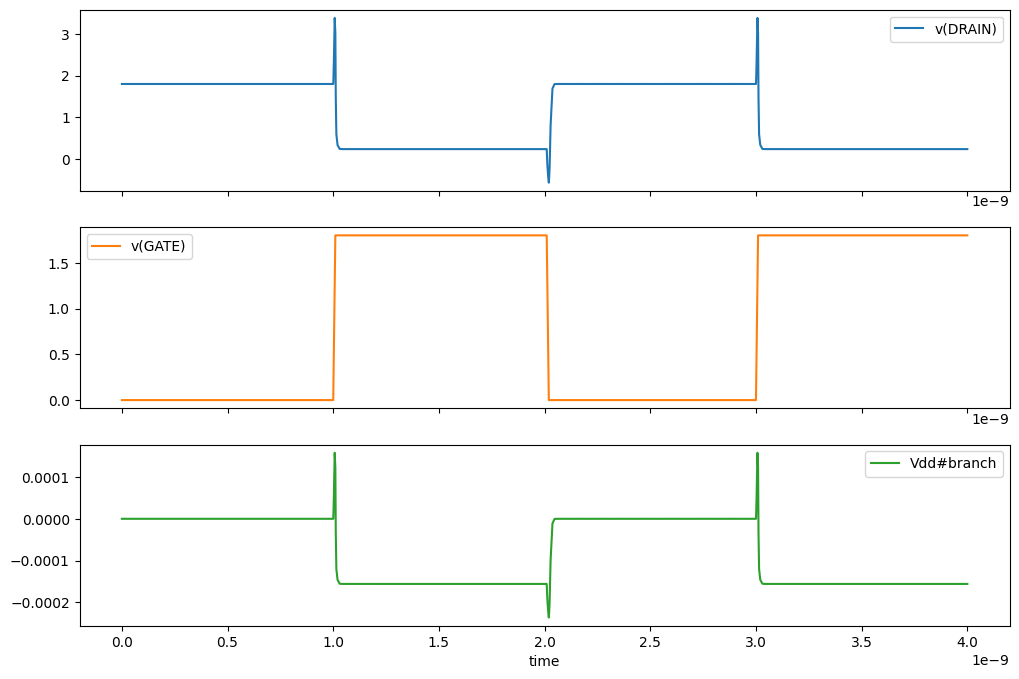

,v(DRAIN),v(GATE),Vdd#branch
time,,,
0.000000e+00,1.800000,0.0,-1.945826e-12
1.000000e-13,1.800000,0.0,-1.945826e-12
2.000000e-13,1.800000,0.0,-1.945826e-12
4.000000e-13,1.800000,0.0,-1.945826e-12
8.000000e-13,1.800000,0.0,-1.945826e-12
...,...,...,...
3.960353e-09,0.243100,1.8,-1.556900e-04
3.970353e-09,0.243124,1.8,-1.556876e-04
3.980353e-09,0.243101,1.8,-1.556899e-04


In [116]:
# read and plot data with python
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("mosfet_tb.csv", delim_whitespace = True, skip_blank_lines=True )
data = data.set_index('time')
data.plot(subplots=True, figsize=(12, 8))
plt.show()
data

## Example2: NAND Gate

### Netlist

Important parts

- Add technology library and cell definition if required
- schematic
- control statements (follow this structure and play with different options)

result
- results are saved in .csv format (nand_tb.csv)


In [117]:
%%writefile nand_tb.cir

* NAME Testbench

.title sky130_fd_sc_hd__nand2_1

* .include /content/skywater-pdk-libs-sky130_fd_sc_hd/cells/nand2/sky130_fd_sc_hd__nand2_1.spice
* .lib /usr/local/share/pdk/sky130A/libs.tech/ngspice/sky130.lib.spice tt

* technology - standard cellspice definitions
.include /content/skywater-pdk-libs-sky130_fd_sc_hd/cells/nand2/sky130_fd_sc_hd__nand2_1.spice

* technology- spice models
.lib /content/skywater-pdk-libs-sky130_fd_pr/models/sky130.lib.spice tt

* schematic definition
.PARAM vdd = 2.5
Xcell A B VGND VNB VPB VPWR Y sky130_fd_sc_hd__nand2_1
Vgnd VGND 0 0
Vdd VPWR VGND {vdd}
Va A VGND DC 0V PULSE(0V {vdd} 1ns 10ps 10ps 1ns 2ns)
Vb B VGND DC 0V PULSE(0V {vdd} 1.5ns 10ps 10ps 1ns 2ns)

* Control statements
.CONTROL
    tran 10p 4n
    set filetype=ascii
    option noinit
    set wr_singlescale
    set wr_vecnames
    save all
    save allcurrents
    run
    wrdata nand_tb.csv V(A) V(B) V(Y) Vdd#branch
.ENDC
.END

Overwriting nand_tb.cir


### Run Simulation

Run Simulation with `ngspice` in batch mode


In [118]:
# run sim
!ngspice -b nand_tb.cir


Compatibility modes selected: hs a



Circuit: sky130_fd_sc_hd__nand2_1

option SCALE: Scale is set to 1e-06 for instance and model parameters
Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


Initial Transient Solution
--------------------------

Node                                   Voltage
----                                   -------
sky130_fd_pr__esd_nfet_05v0_nvt.pm3               0
                                             0
y                                          2.5
a                                            0
vpwr                                       2.5
vpb                                    2.50001
b                                            0
vgnd                                         0
vnb                                   0.178875
vb#branch                                    0
va#branch                                    0
vdd#branch                        -2.33445e-12
vgnd#branch                        3.47533e-17

 Reference value :  0.00000e+00


### Read and plot Result with Ptython


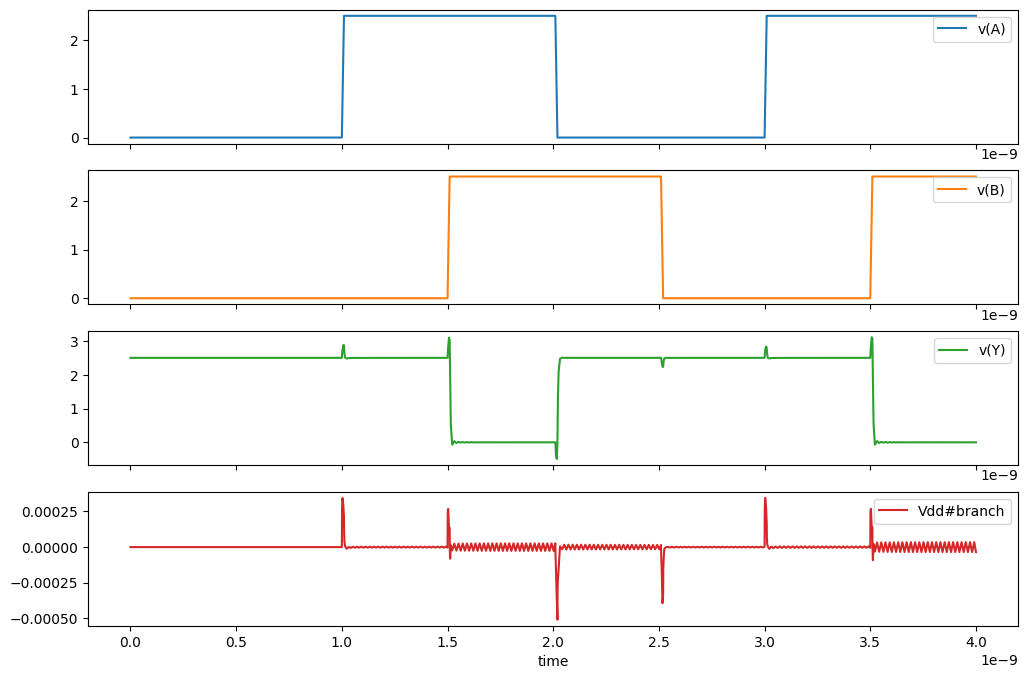

,v(A),v(B),v(Y),Vdd#branch
time,,,,
0.000000e+00,0.0,0.0,2.500000,-2.334452e-12
1.000000e-13,0.0,0.0,2.500000,-2.334476e-12
2.000000e-13,0.0,0.0,2.500000,-2.334483e-12
4.000000e-13,0.0,0.0,2.500000,-2.334508e-12
8.000000e-13,0.0,0.0,2.500000,-2.334464e-12
...,...,...,...,...
3.962000e-09,2.5,2.5,-0.000154,-3.508755e-05
3.972000e-09,2.5,2.5,0.000148,3.509281e-05
3.982000e-09,2.5,2.5,-0.000141,-3.509797e-05


In [119]:
# read and plot data with python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("nand_tb.csv", delim_whitespace = True, skip_blank_lines=True )
data = data.set_index('time')
data.plot(subplots=True, figsize=(12, 8))
plt.show()
data